In [1]:
import time
import warnings

import numpy as np
import numpy.linalg as LA
import scipy.linalg as SLA
from scipy import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import ortho_group
from IPython import display

# RNN cell #

In [2]:
class rnn_const_mid(layers.Layer):
    def __init__(self, dimx, dimz):
        super(rnn_const_mid, self).__init__()
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units,)
        
    def build(self, input_shapes):
        # R's entries are likely to be small (dtRt)
        self.R = self.add_weight(
            shape=(self.units, self.dimx), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        ) 
        # W is supposed to be a small perturbation of the identity matrix
        # dt/2*D (=0)
        self.sym = self.add_weight(
            shape=(self.units,), 
            initializer=keras.initializers.Constant(value=0.), 
            constraint=keras.constraints.NonNeg(), name="hidden_sym"
        )
         
        self.asym = self.add_weight(
            shape=(self.units, self.units), 
            initializer=keras.initializers.Constant(value=0.), 
            name="hidden_asym"
        )
        # z0
        self.z0 = self.add_weight(
            shape=(1,self.units), 
            initializer=keras.initializers.Constant(value=0.), 
            name="hidden_const"
        )
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i (agrees with 0 initial state)
        # inputs are all x0 (unnecessary)
        # outputs are x1-x0, x2-x1,..., xN-xN-1
        dM = -tf.linalg.diag(self.sym) + self.asym - tf.transpose(self.asym)
        Ml = tf.eye(self.units) - dM
        Mr = tf.eye(self.units) + dM
        zi = states[0]
        zip1 = (2*self.z0 @ dM  + zi @ Mr) @ tf.linalg.inv(Ml) 
        dx = (self.z0 + 0.5*(zi+zip1)) @ self.R
        return dx, [zip1]

In [3]:
class rnn_const_mid_t(layers.Layer):
    def __init__(self, dimx, dimz):
        super(rnn_const_mid_t, self).__init__()
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units,)
        
    def build(self, input_shapes):
        # R's entries are likely to be small (dtRt)
        self.R = self.add_weight(
            shape=(self.units, self.dimx), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        ) 
        # W is supposed to be a small perturbation of the identity matrix
        # dt/2*D (=0)
        self.sym = self.add_weight(
            shape=(self.units,), 
            initializer=keras.initializers.Constant(value=0.), 
            constraint=keras.constraints.NonNeg(), name="hidden_sym"
        )
         
        self.asym = self.add_weight(
            shape=(self.units, self.units), 
            initializer=keras.initializers.Constant(value=0.), 
            name="hidden_asym"
        )
        # z0
        self.z0 = self.add_weight(
            shape=(1,self.units), 
            initializer=keras.initializers.Constant(value=0.), 
            name="hidden_const"
        )
        # trans
        self.v = self.add_weight(
            shape=(1,self.dimx), 
            initializer=keras.initializers.Constant(value=0.), 
            name="trans_const"
        )
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i (agrees with 0 initial state)
        # inputs are all x0 (unnecessary)
        # outputs are x1-x0, x2-x1,..., xN-xN-1
        dM = -tf.linalg.diag(self.sym) + self.asym - tf.transpose(self.asym)
        Ml = tf.eye(self.units) - dM
        Mr = tf.eye(self.units) + dM
        zi = states[0]
        zip1 = (2*self.z0 @ dM  + zi @ Mr) @ tf.linalg.inv(Ml) 
        dx = (self.z0 + 0.5*(zi+zip1)) @ self.R + self.v
        return dx, [zip1]

# Build Model #

In [4]:
def build_const_mid_model(x_dim, hidden_dim, time_steps):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_mid(x_dim, hidden_dim)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, x_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_mid_rom")
    return model

In [5]:
def build_const_midt_model(x_dim, hidden_dim, time_steps):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_mid_t(x_dim, hidden_dim)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, x_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_midt_rom")
    return model

# Data loading #

In [6]:
def load_data(filepath, cutoff=400):
    matlab_data = io.loadmat(filepath)
    xs = matlab_data['xs']
    x0 = xs[0]
    x0s = np.array([np.tile(x0, (cutoff, 1))])
    xdata = np.array([xs[1:cutoff+1]-xs[:cutoff]])
    mag_dx = abs(xdata).max()
    train_dataset = tf.data.Dataset.from_tensor_slices((x0s, 1/mag_dx*xdata)).batch(1)
    xtest = np.array([xs])
    return matlab_data, cutoff, mag_dx, train_dataset, xtest

# Test Routine #

In [7]:
def lsim(x0, n_step, rnncell):
    h = tf.zeros((1,rnncell.units))
    inputs = tf.convert_to_tensor([x0], dtype=tf.float32)
    state = [h]
    xs_p = []
    for _ in range(n_step):
        x, state = rnncell.call(inputs, state)
        xs_p.append(x.numpy().reshape(x0.shape[0],))
    return mag_dx*np.array(xs_p) # shape (n_step, dimx) 

In [8]:
def test_traj_plot(cus_model, x_true, n_step=None, randcomp=False):
    # x_true has shape (samples, ts, dimx)
    sample_id = np.random.randint(x_true.shape[0])
    
    xdata = x_true[sample_id]
    dimx = xdata.shape[-1]
    
    x0 = xdata[0]
    if n_step is None:
        n_step = xdata.shape[0]-1
    comp_id = 0
    if randcomp:
        comp_id = np.random.randint(x_true.shape[2])
    rnncell = cus_model.layers[1].cell
    dx = lsim(x0, n_step, rnncell)
    x_pred = np.vstack((x0, np.cumsum(dx, axis=0)+x0))
    plt.plot(xdata[:,comp_id], label='true')
    plt.plot(x_pred[:,comp_id], label='pred')
    plt.legend()
    plt.title(f"Sample ID: {sample_id} Test Trajectory of component {comp_id}")
    return x_pred

In [9]:
def rotation(x_pred, x_true, pause=0.001):
    xdata = x_true[0]
    xdim = x_pred.shape[-1]//2
    x_ub = xdata[-1,:xdim].mean()+0.5
    if x_pred.shape[0] > xdata.shape[0]:
        apd_len = x_pred.shape[0] - xdata.shape[0]
        xdata = np.vstack((xdata, xdata[1:apd_len+1, :]))
    for i in range(x_pred.shape[0]):
        display.clear_output(wait=True)
        pred = x_pred[i]
        xtrue = xdata[i]
        x0 = np.append(xtrue[:xdim], xtrue[0])
        y0 = np.append(xtrue[xdim:], xtrue[xdim])

        x1 = np.append(pred[:xdim], pred[0])
        y1 = np.append(pred[xdim:], pred[xdim])
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        ax.plot(x0,y0,label='true')
        ax.plot(x1,y1,label='pred')
        ax.set_aspect('equal')
        ax.legend()
        ax.set_xlim(0, x_ub)
        ax.set_ylim(0, 1)
        plt.show()
        time.sleep(pause)

# Training #

In [10]:
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = keras.metrics.MeanSquaredError()

In [11]:
def train_fcns(model, lr):
    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # define training and validation functions
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            yout = model(x, training=True)
            loss_value = loss_fn(y, yout)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, yout)
        return loss_value 
    return train_step

In [12]:
def train_loop(epochs, train_step):
    neprint = 20
    for epoch in range(epochs):
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        if (epoch+1) % neprint==0:
            print(f"Training acc over epoch: {float(train_acc):.6f}")
            print("Time taken: %.2fs" % (time.time() - start_time))

# Example #

## 32 points no transport

In [13]:
_, cutoff, mag_dx, train_dataset, xtest_o = load_data('../matlab/cell_rotation_32.mat')

In [14]:
cell_rot32 = build_const_mid_model(64, 20, cutoff)
cell_rot32.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 64)]         0         
_________________________________________________________________
rnn (RNN)                    (None, 400, 64)           1720      
Total params: 1,720
Trainable params: 1,720
Non-trainable params: 0
_________________________________________________________________


In [15]:
cell_rot32.load_weights('model_weights/cell_rot32.h5')

In [64]:
train_step = train_fcns(cell_rot32, 1e-4)

In [76]:
train_loop(100, train_step)

Training acc over epoch: 0.000062
Time taken: 0.06s
Training acc over epoch: 0.000060
Time taken: 0.06s
Training acc over epoch: 0.000058
Time taken: 0.06s
Training acc over epoch: 0.000057
Time taken: 0.06s
Training acc over epoch: 0.000055
Time taken: 0.06s


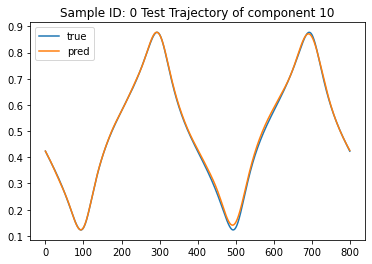

In [16]:
x_pred_o = test_traj_plot(cell_rot32, xtest_o, n_step=800, randcomp=True)

In [17]:
np.save('data/roto_test.npy', xtest_o)
np.save('data/roto_pred.npy', x_pred_o)

In [18]:
xtest_o.shape

(1, 801, 64)

In [19]:
x_pred_o.shape

(801, 64)

In [97]:
def plot_angle(x_pred, x_true):
    dim = x_true.shape[-1]
    tx = x_true[0,:,0]
    ty = x_true[0,:,dim // 2]
    cxt = (x_true[0,:,0] + x_true[0,:,dim // 4])/2
    cyt = (x_true[0,:,dim // 8 * 5] + x_true[0,:,dim // 8 * 7])/2
    px = x_pred[:,0]
    py = x_pred[:,dim // 2]
    cxp = (x_pred[:,0] + x_pred[:,dim // 4])/2
    cyp = (x_pred[:,dim // 8 * 5] + x_pred[:,dim // 8 * 7])/2
    ta = (ty-cyt)/(tx-cxt)
    tp = (py-cyp)/(px-cxp)
    plt.plot(np.arctan(ta), linewidth=5, label='true')
    plt.plot(np.arctan(tp), '--', linewidth=5, label='pred')
    plt.legend(loc = 1, prop={'size': 24})
    plt.xticks(list(range(0,801,200)), fontsize = 24)
    plt.yticks(fontsize = 24)
    plt.xlim(0,1100)
    plt.xlabel('time step' ,fontsize = 24)
    plt.ylabel('angle (rad)', fontsize = 24)

D:\miniconda3\envs\tf-gpu-mlor\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


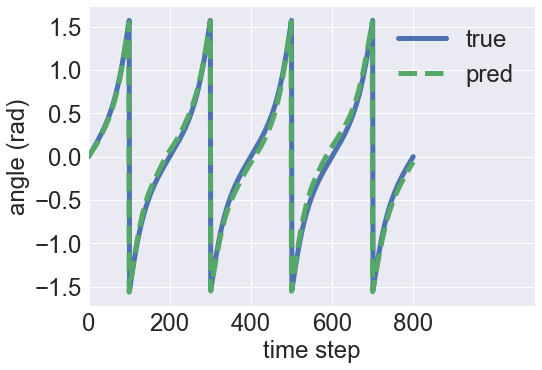

In [98]:
plot_angle(x_pred_o, xtest_o)
plt.savefig(f"../Notes/roto_angle.png")

In [68]:
def plot_snapshots(x_test, x_pred, test_step):
    dim = x_pred.shape[-1]
    x_true = np.append(x_test[0,test_step,:dim//2], x_test[0,test_step,0]) 
    y_true = np.append(x_test[0,test_step,dim//2:], x_test[0,test_step,dim//2])
    x_p = np.append(x_pred[test_step,:dim//2], x_pred[test_step,0])
    y_p = np.append(x_pred[test_step,dim//2:], x_pred[test_step,dim//2])
    
    cxp, cyp = x_true[:-1].mean(), y_true[:-1].mean()
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_title(f"Snapshot at time step: {test_step}", fontsize=50)
    ax.plot(x_true, y_true, linewidth=5, label="true")
    ax.plot(x_p, y_p, '--', linewidth=5, label="pred")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.legend(prop={'size': 50}, loc=1)
    ax.set_xlim(cxp-.5, cxp+.5)
    ax.set_ylim(cyp-.5, cyp+.5)

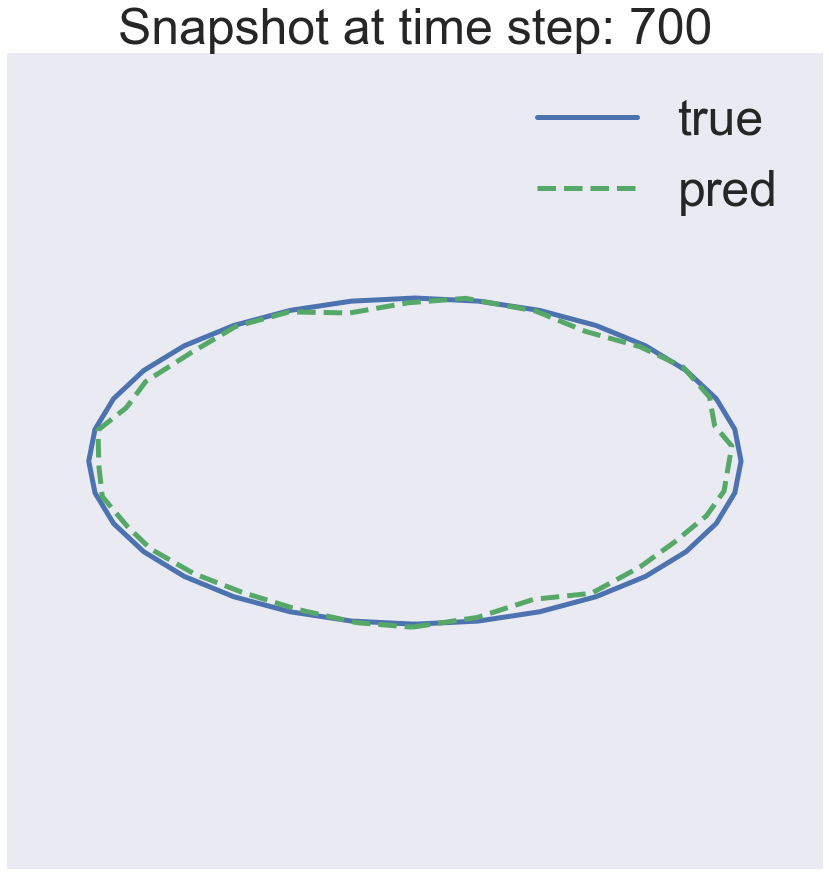

In [73]:
test_step = 700
plot_snapshots(xtest_o, x_pred_o, test_step)
plt.savefig(f"../Notes/roto_snap{test_step}.png")

In [ ]:
rotation(x_pred_o, xtest_o)

In [70]:
cell_rot32.save_weights('model_weights/cell_rot32.h5')

## 32 points with transport

In [13]:
_, cutoff, mag_dx, train_dataset, xtest_t = load_data('../matlab/cell_rot_trans.mat')

In [14]:
cell_rt = build_const_midt_model(64, 20, cutoff)
cell_rt.summary()

Model: "const_midt_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 64)]         0         
_________________________________________________________________
rnn (RNN)                    (None, 400, 64)           1784      
Total params: 1,784
Trainable params: 1,784
Non-trainable params: 0
_________________________________________________________________


In [15]:
cell_rt.load_weights('model_weights/cell_rt.h5')

In [17]:
rnncell = cell_rt.layers[1].cell

In [79]:
dtrec = 100
mmat = np.diag(-rnncell.sym.numpy())+2*dtrec*(rnncell.asym.numpy().T-rnncell.asym.numpy())
msys = np.vstack((np.hstack((mmat, np.zeros((20, 64)))), np.hstack((dtrec*rnncell.R.numpy().T, np.zeros((64,64))))))
e, v = LA.eig(msys)
np.save('data/rot_eigs.npy', e)

In [142]:
train_step = train_fcns(cell_rt, 1e-4)

In [149]:
train_loop(100, train_step)

Training acc over epoch: 0.000072
Time taken: 0.06s
Training acc over epoch: 0.000070
Time taken: 0.06s
Training acc over epoch: 0.000068
Time taken: 0.06s
Training acc over epoch: 0.000067
Time taken: 0.06s
Training acc over epoch: 0.000065
Time taken: 0.06s


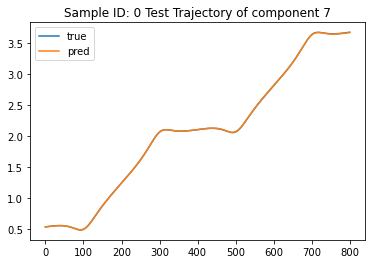

In [21]:
x_pred_t = test_traj_plot(cell_rt, xtest_t, n_step=800, randcomp=True)

In [22]:
np.save('data/rott_test.npy', xtest_t)
np.save('data/rott_pred.npy', x_pred_t)

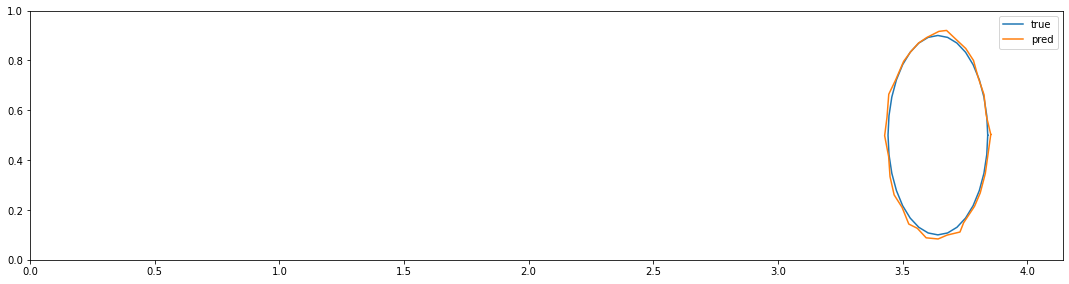

In [24]:
rotation(x_pred_t, xtest_t)

In [156]:
cell_rt.save_weights('model_weights/cell_rt.h5')

D:\miniconda3\envs\tf-gpu-mlor\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


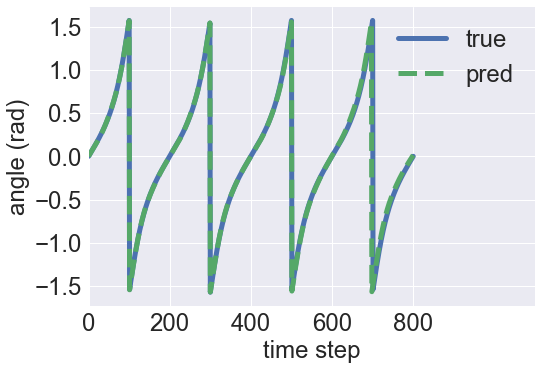

In [99]:
plot_angle(x_pred_t, xtest_t)
plt.savefig(f"../Notes/rott_angle.png")

In [128]:
def plot_rott(x_test, x_pred, ids):
    dim = x_test.shape[-1]
    x_ub = x_test[0,-1,:dim//2].mean() + 0.5
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    for test_step in ids:
        x_true = np.append(x_test[0,test_step,:dim//2], x_test[0,test_step,0]) 
        y_true = np.append(x_test[0,test_step,dim//2:], x_test[0,test_step,dim//2])
        x_p = np.append(x_pred[test_step,:dim//2], x_pred[test_step,0])
        y_p = np.append(x_pred[test_step,dim//2:], x_pred[test_step,dim//2])
        lt, = ax.plot(x_true,y_true, 'b', linewidth=5)
        lp, = ax.plot(x_p,y_p, 'g--', linewidth=5)
    ax.set_aspect('equal')
    ax.legend([lt, lp], ['true', 'pred'], prop={'size': 25})
    ax.set_xlim(0, x_ub)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

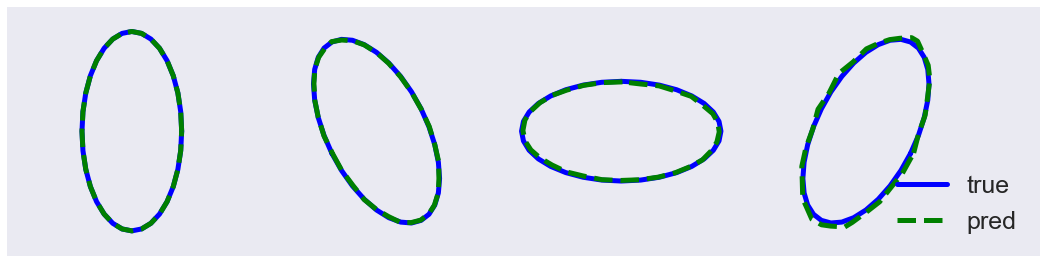

In [129]:
plot_rott(xtest_t, x_pred_t, [0, 250, 500, 750])
plt.savefig(f"../Notes/rott_snaps.png")

In [109]:
def plot_center(x_pred, x_true):
    dim = x_true.shape[-1]
    cxt = (x_true[0,:,0] + x_true[0,:,dim // 4])/2
    cxp = (x_pred[:,0] + x_pred[:,dim // 4])/2
    plt.plot(cxt-cxt[0], linewidth=5, label='true')
    plt.plot(cxp-cxp[0], '--', linewidth=5, label='pred')
    plt.legend(loc = 0, prop={'size': 24})
    plt.xticks(list(range(0,801,200)), fontsize = 24)
    plt.yticks(fontsize = 24)
    plt.xlabel('time step' ,fontsize = 24)
    plt.ylabel('displacement', fontsize = 24)

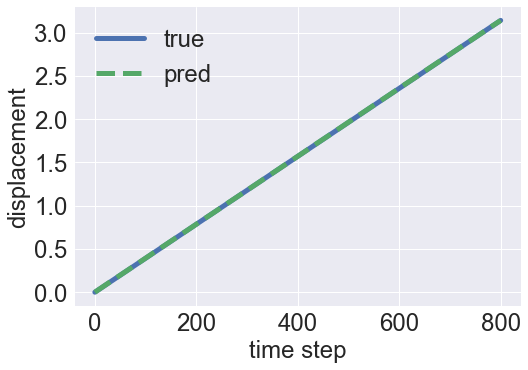

In [111]:
plot_center(x_pred_t, xtest_t)
plt.savefig(f"../Notes/rott_disp.png")